In [1]:
# Change the number of cores in this code block
# by setting `spark.master` to `local[n]` where
# n is the number of cores
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import matplotlib.pyplot as plt

conf = pyspark.SparkConf().setAll([('spark.master', 'local[4]'),
                                   ('spark.app.name', 'Data Prep'),
                                   ('spark.memory.offHeap.enabled', True),
                                   ('spark.memory.offHeap.size','4g'),
                                   ('spark.executor.memory', '4g'), 
                                   ('spark.driver.memory','6g')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-23 20:30:11,323 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Set params
write_files = True
filter_ratings = True
rating_cap = 125
train_test_ratio = [.7,.3]
seed = 0

## Read in data  

In [3]:
ratings_df = spark.read.csv("file:///home/work/data/ratings.csv", inferSchema=True, header=True)
ratings_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [4]:
movies_df = spark.read.csv("file:///home/work/data/final_movies_df_10.csv", inferSchema=True, header=True)
movies_df.printSchema()
print(f"Total distinct movies: {movies_df.count()}")

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- movieYear: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- Crime: double (nullable = true)
 |-- Romance: double (nullable = true)
 |-- Thriller: double (nullable = true)
 |-- Adventure: double (nullable = true)
 |-- Drama: double (nullable = true)
 |-- War: double (nullable = true)
 |-- Documentary: double (nullable = true)
 |-- Fantasy: double (nullable = true)
 |-- Mystery: double (nullable = true)
 |-- Musical: double (nullable = true)
 |-- Animation: double (nullable = true)
 |-- Film-Noir: double (nullable = true)
 |-- Horror: double (nullable = true)
 |-- Western: double (nullable = true)
 |-- Comedy: double (nullable = true)
 |-- Children: double (nullable = true)
 |-- Action: double (nullable = true)
 |-- Sci-Fi: double (nullable = true)

Total distinct movies: 24009


## Drop movies  

In [5]:
movies_df.createOrReplaceTempView("m")
ratings_df.createOrReplaceTempView("r")

In [6]:
tot_r = ratings_df.count()
ratings_df = spark.sql("SELECT r.userId, r.movieId, r.rating, r.timestamp FROM r JOIN m ON r.movieId == m.movieId")
tot_g = ratings_df.count()
percent_lost = (((tot_r - tot_g) / tot_r) * 100)
print(f"Total distinct movies with reviews: {ratings_df.select(col('movieId')).distinct().count()}")
print(f"Total Reviews: {tot_r} Total reviews without genres: {tot_g} Total reviews after dropping: {tot_r - tot_g}")
print(f"If drop ratings for movies without genres, we will lose {percent_lost:.3f}% of ratings data.")

spark.sql("drop view r");
ratings_df.createOrReplaceTempView("r")

Total distinct movies with reviews: 24009
Total Reviews: 25000095 Total reviews without genres: 24873798 Total reviews after dropping: 126297
If drop ratings for movies without genres, we will lose 0.505% of ratings data.


## Filter ratings

In [7]:
if filter_ratings:
    median_ratings = spark.sql("SELECT r.userId, COUNT(r.userId) as tot_ratings FROM r GROUP BY r.userId HAVING COUNT(r.userId) <= {} ORDER BY r.userId DESC".format(rating_cap))
    tot_ratings = median_ratings.agg(sum("tot_ratings")).collect()[0][0]
    print(f"Total ratings: {tot_ratings}")
    median_ratings.createOrReplaceTempView("med_r")

    ratings_df = spark.sql("SELECT r.userId, r.movieId, r.rating, r.timestamp FROM r RIGHT JOIN med_r ON r.userId == med_r.userId")
    tot_ratings = ratings_df.count()
    print(f"Total distinct movies with reviews: {ratings_df.select(col('movieId')).distinct().count()}")
    print(f"Total Reviews: {tot_ratings}")

Total ratings: 5957410


Total distinct movies with reviews: 19381
Total Reviews: 5957410


In [8]:
# ratings_dist = ratings_df.groupBy('rating').count()
# # .sort(col("rating").asc())
# ratings_dist = ratings_dist.toPandas()
# # font = {'family' : 'DejaVu Sans',
# #         'weight' : 'bold',
# #         'size'   : 22}

# # plt.rc('font', **font)

# plt.figure(figsize=(10,10))
# plt.bar(ratings_dist["rating"], ratings_dist["count"],width=1,align='center',edgecolor='k')
# plt.title("Rating Distribution")
# plt.ylabel("Count (Million)")
# plt.xlabel("Rating")
# # ax = plt.gca()
# # ax.set_xticks(ratings_dist["rating"])

## Timestamps

In [9]:
ratings_df = ratings_df.withColumn('date',from_unixtime(col("timestamp"))).withColumn('year',year("date"))
spark.sql("drop view r");
ratings_df.createOrReplaceTempView("r")

In [10]:
ratings_df.show()

+------+-------+------+---------+-------------------+----+
|userId|movieId|rating|timestamp|               date|year|
+------+-------+------+---------+-------------------+----+
|162514|      1|   3.0|883850636|1998-01-03 18:03:56|1998|
|162514|     34|   5.0|883850804|1998-01-03 18:06:44|1998|
|162514|     50|   3.0|883850591|1998-01-03 18:03:11|1998|
|162514|    110|   4.0|883850804|1998-01-03 18:06:44|1998|
|162514|    296|   4.0|883850688|1998-01-03 18:04:48|1998|
|162514|    527|   5.0|883850591|1998-01-03 18:03:11|1998|
|162514|    593|   4.0|883850725|1998-01-03 18:05:25|1998|
|162514|    596|   3.0|883850756|1998-01-03 18:05:56|1998|
|162514|    670|   4.0|883850688|1998-01-03 18:04:48|1998|
|162514|    728|   3.0|883850804|1998-01-03 18:06:44|1998|
|162514|    750|   4.0|883850920|1998-01-03 18:08:40|1998|
|162514|    800|   4.0|883850636|1998-01-03 18:03:56|1998|
|162514|    858|   3.0|883850833|1998-01-03 18:07:13|1998|
|162514|    904|   4.0|883850725|1998-01-03 18:05:25|199

### Plot year distribution

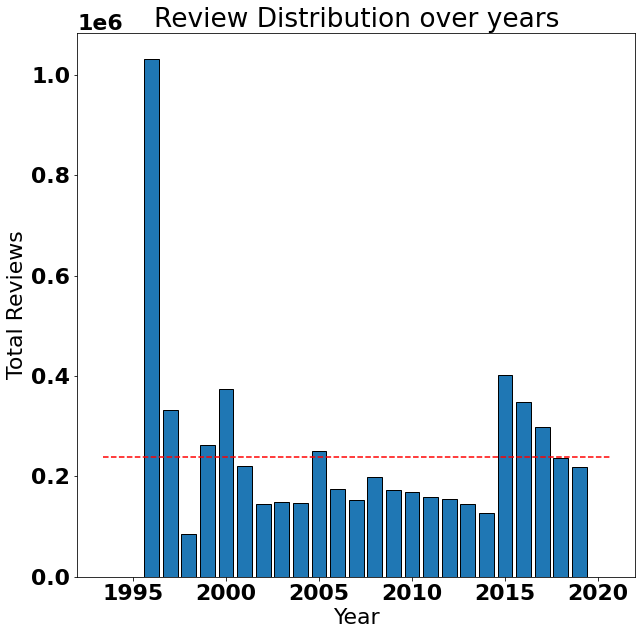

In [11]:
ratings_pd = ratings_df.groupBy("year").count().sort('count').toPandas()

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

plt.figure(figsize=(10,10))
plt.bar(ratings_pd["year"], ratings_pd["count"],edgecolor='k')

# plot average
ax = plt.gca()
x_lims = ax.get_xlim()
plt.hlines(ratings_pd["count"].mean(), x_lims[0], x_lims[1], colors='r', linestyles='--')

plt.title("Review Distribution over years")
plt.ylabel("Total Reviews")
plt.xlabel("Year")
ax = plt.gca()
# plt.savefig('file:///home/work/data/count_review_dist.png')

Text(0.5, 0, 'Year')

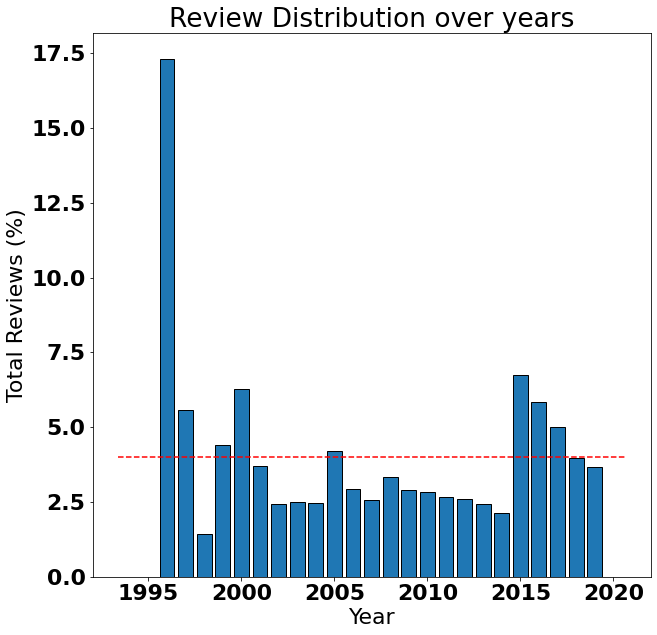

In [12]:
# Plot as percentage
ratings_pd["prop"] = (ratings_pd["count"] / ratings_pd["count"].sum()) * 100
plt.figure(figsize=(10,10))
plt.bar(ratings_pd["year"], ratings_pd["prop"],edgecolor='k')
# plot average
ax = plt.gca()
x_lims = ax.get_xlim()
plt.hlines(ratings_pd["prop"].mean(), x_lims[0], x_lims[1], colors='r', linestyles='--')

plt.title("Review Distribution over years")
plt.ylabel("Total Reviews (%)")
plt.xlabel("Year")
# plt.savefig('file:///home/work/data/percentage_review_dist.png')

## Ratings relative to first review
ie: how many users left reviews within 1 year, 2 years, 3, ...

In [13]:
#Find min timestamps for each group
min_ts_df = spark.sql("SELECT r.userId, MIN(r.timestamp) as min_ts FROM r GROUP BY r.userId ORDER BY r.userId ASC")
min_ts_df.createOrReplaceTempView("min_ts")
min_ts_df.show()

+------+----------+
|userId|    min_ts|
+------+----------+
|     1|1147868053|
|     5| 830786155|
|     6| 945141530|
|     7| 835444730|
|    10|1227570828|
|    11|1208038679|
|    14|1506208807|
|    15| 946011308|
|    16|1432077522|
|    17|1485581429|
|    20|1061997999|
|    21|1456284469|
|    22| 832862128|
|    24|1366519990|
|    25| 836216894|
|    26|1280513623|
|    27| 974256316|
|    28| 951086053|
|    29|1340065776|
|    30|1488510832|
+------+----------+
only showing top 20 rows



In [14]:
# Calculate difference
diff_df = spark.sql("SELECT r.userId, r.movieId, (r.timestamp - min_ts.min_ts) as time_diff  FROM r JOIN min_ts ON r.userId == min_ts.userId ORDER BY r.userId ASC")
diff_df = diff_df.withColumn('time_diff_years', round((col("time_diff") / (3600 * 24 * 365))))
diff_df.show()

+------+-------+---------+---------------+
|userId|movieId|time_diff|time_diff_years|
+------+-------+---------+---------------+
|     1|    296|    11991|            0.0|
|     1|    306|      764|            0.0|
|     1|    307|      775|            0.0|
|     1|    665|    10767|            0.0|
|     1|    899|      457|            0.0|
|     1|   1088|      442|            0.0|
|     1|   1175|      773|            0.0|
|     1|   1217|    10273|            0.0|
|     1|   1237|      786|            0.0|
|     1|   1250|      361|            0.0|
|     1|   1260|     9804|            0.0|
|     1|   1653|       44|            0.0|
|     1|   2011|       26|            0.0|
|     1|   2012|       15|            0.0|
|     1|   2068|      991|            0.0|
|     1|   2161|      556|            0.0|
|     1|   2351|     9904|            0.0|
|     1|   2573|    10870|            0.0|
|     1|   2632|    10195|            0.0|
|     1|   2692|     1047|            0.0|
+------+---

In [15]:
# Count the occurences
diff_pd = diff_df.groupBy("time_diff_years").count().sort('count').toPandas()
diff_pd = diff_pd.rename(columns={"time_diff_years": "years"})
diff_pd = diff_pd.reset_index(drop=True)
# Add proportion
diff_pd["prop"] = (diff_pd["count"] / diff_pd["count"].sum()) * 100
diff_pd.sort_values(by=['count'], ascending=False)

,years,count,prop
20,0.0,5793371,97.246471
19,1.0,95022,1.595022
18,2.0,31683,0.531825
17,3.0,15959,0.267885
16,4.0,7461,0.125239
15,5.0,4673,0.078440
14,6.0,2975,0.049938
13,7.0,2157,0.036207
12,9.0,1252,0.021016
11,8.0,1045,0.017541


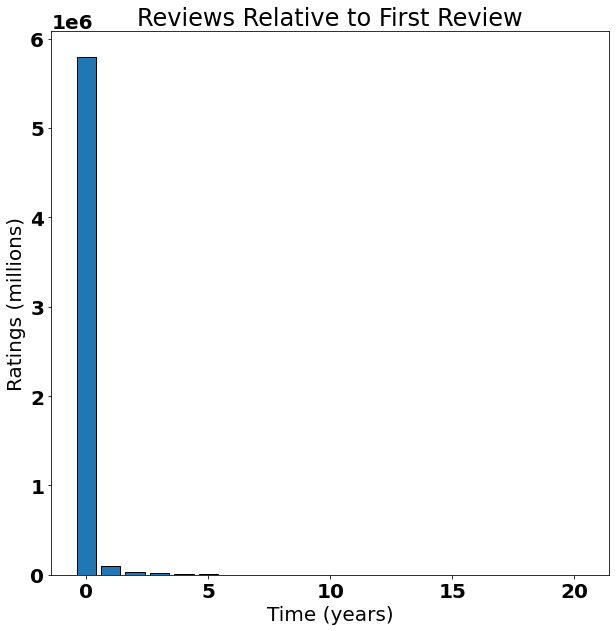

In [16]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)

plt.figure(figsize=(10,10))
plt.bar(diff_pd["years"], diff_pd["count"],edgecolor='k')
plt.title("Reviews Relative to First Review")
plt.ylabel("Ratings (millions)")
plt.xlabel("Time (years)")
ax = plt.gca()

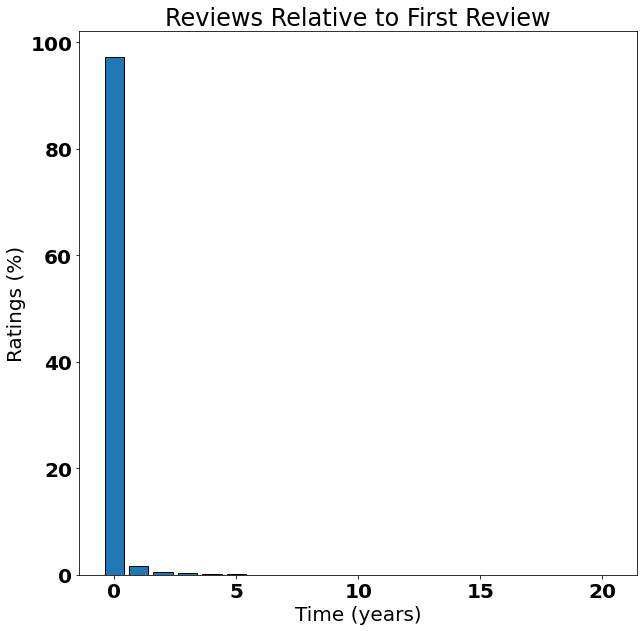

In [17]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)

plt.figure(figsize=(10,10))
plt.bar(diff_pd["years"], diff_pd["prop"],edgecolor='k')
plt.title("Reviews Relative to First Review")
plt.ylabel("Ratings (%)")
plt.xlabel("Time (years)")
ax = plt.gca()

In [18]:
# put together cleaned ratings
r_q = "r.userId, r.movieId, r.rating, "
movie_cols = movies_df.columns
# exc_cols = ['movieId', 'title', 'movieYear']
inc_cols = ['genres', 'avg_rating']
movie_cols = sorted(list(set(movie_cols).intersection(set(inc_cols))))
m_q = ", ".join(["m.`" + c + "`" if '-' in c else "m." + c for c in movie_cols])
query = "SELECT " + r_q + m_q + " FROM r JOIN m ON r.movieId == m.movieId"
final_df = spark.sql(query)

In [19]:
# check final_df before saving
final_df.createOrReplaceTempView("f")
spark.sql("SELECT COUNT(f.movieId) FROM f").show()

+--------------+
|count(movieId)|
+--------------+
|       5957410|
+--------------+



In [20]:
final_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- genres: string (nullable = true)



In [21]:
train, test = final_df.randomSplit(train_test_ratio, seed=seed)
print(f"Train observations: {train.count()} Test observations: {test.count()}")

Train observations: 4169498 Test observations: 1787912


In [22]:
# save final_df
if write_files:
    train.coalesce(1).write.csv("hdfs:///train", header=True)
    !hadoop fs -ls /train
    !hadoop fs -copyToLocal /train/part-*.csv /home/work/data/
    
    test.coalesce(1).write.csv("hdfs:///test", header=True)
    !hadoop fs -ls /test
    !hadoop fs -copyToLocal /test/part-*.csv /home/work/data/
    
    !hadoop fs -rm -r /train
    !hadoop fs -rm -r /test

Found 2 items
-rw-r--r--   1 root supergroup          0 2022-05-23 20:35 /train/_SUCCESS
-rw-r--r--   1 root supergroup  225739209 2022-05-23 20:35 /train/part-00000-51761a2a-8710-4ad4-b2b3-cebdbfb08a68-c000.csv


Found 2 items
-rw-r--r--   1 root supergroup          0 2022-05-23 20:35 /test/_SUCCESS
-rw-r--r--   1 root supergroup   96824266 2022-05-23 20:35 /test/part-00000-e4621433-d13b-4c1e-b35c-ef11b91fc250-c000.csv
Deleted /train
Deleted /test


In [23]:
# spark.stop()